In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
def process_and_display(coord_dir):
    """
    Procesa imágenes en dos carpetas:
      - coord_dir: muestra las componentes cromáticas (r, g, b) de cada imagen.
      - wp_dir: muestra la imagen original y su corrección White-Patch.
    """
    # para evitar división por cero uso un valor muy chico
    eps = 1e-6

    def show_chromaticity(img):
        B, G, R = cv2.split(img.astype(np.float32))
        S = R + G + B + eps
        r = R / S
        g = G / S
        b = B / S

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for ax, channel, title in zip(axes, [r, g, b],
                                      ['r = R/(R+G+B)', 'g = G/(R+G+B)', 'b = B/(R+G+B)']):
            ax.imshow(channel, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        plt.show()

    for fname in sorted(os.listdir(coord_dir)):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            print(f'>>> Coordenadas cromáticas: {fname}')
            img = cv2.imread(os.path.join(coord_dir, fname))
            show_chromaticity(img)

>>> Coordenadas cromáticas: CoordCrom_1.png


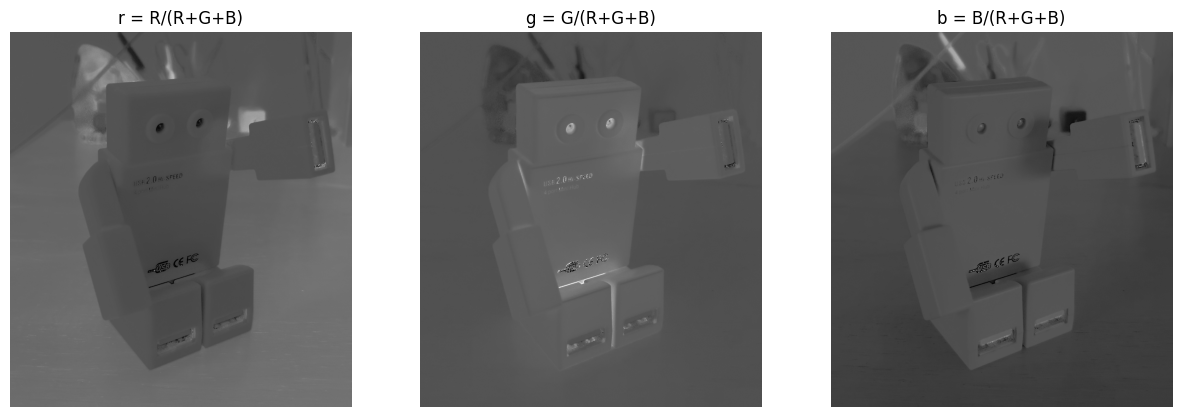

>>> Coordenadas cromáticas: CoordCrom_2.png


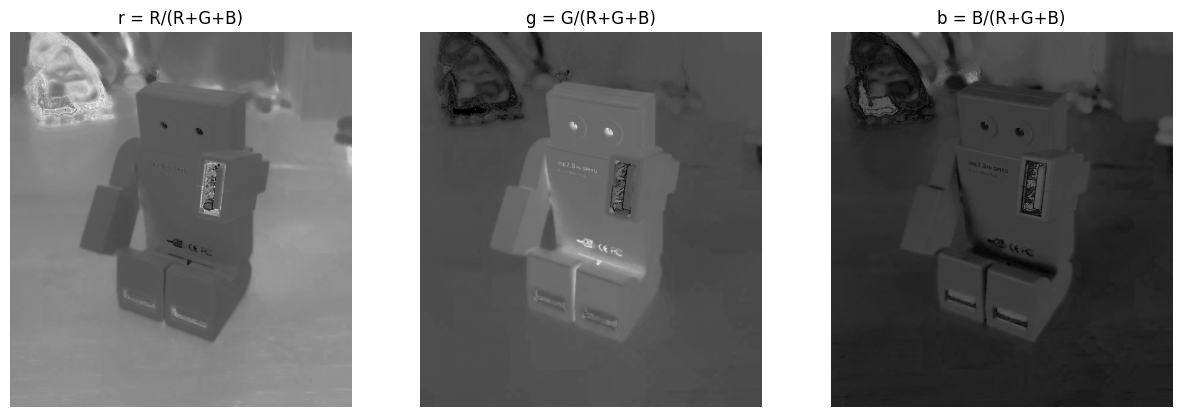

>>> Coordenadas cromáticas: CoordCrom_3.png


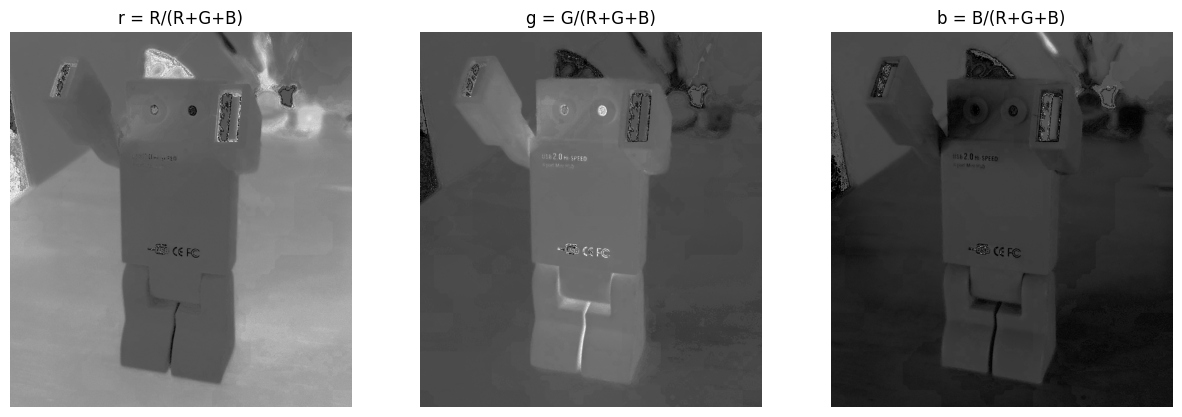

In [25]:
coord_cromaticas = '/content/drive/MyDrive/Material_TPs/TP1/coord_cromaticas'
process_and_display(coord_cromaticas)

In [10]:
def white_patch_correction(img_bgr, eps=1e-6):
    """
    Aplica el algoritmo White‑Patch para corrección de iluminaciones.
    img_bgr: imagen en formato BGR (uint8 o float32)
    eps: pequeña constante para evitar división por cero
    Devuelve la imagen corregida en uint8 (BGR).
    """

    img = img_bgr.astype(np.float32)
    B, G, R = cv2.split(img)

    # Máximos por canal (asumimos que el blanco perfecto está en estos máximos)
    Bm = B.max()
    Gm = G.max()
    Rm = R.max()

    # Escalamos cada canal de modo que su valor máximo llegue a 255
    B_corr = (255.0 / (Bm + eps)) * B
    G_corr = (255.0 / (Gm + eps)) * G
    R_corr = (255.0 / (Rm + eps)) * R

    # Reconstruimos y recortamos a rango válido
    img_corr = cv2.merge([B_corr, G_corr, R_corr])
    img_corr = np.clip(img_corr, 0, 255).astype(np.uint8)

    return img_corr

/content/drive/MyDrive/Material_TPs/TP1/white_patch/test_red.png


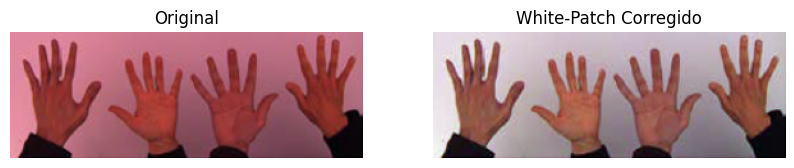

/content/drive/MyDrive/Material_TPs/TP1/white_patch/wp_green.png


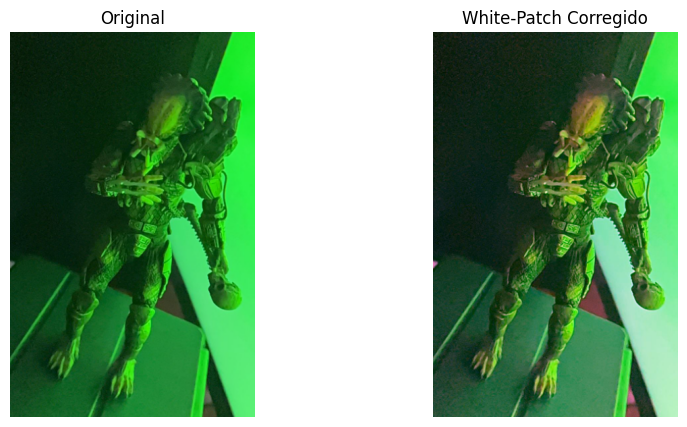

/content/drive/MyDrive/Material_TPs/TP1/white_patch/wp_red.png


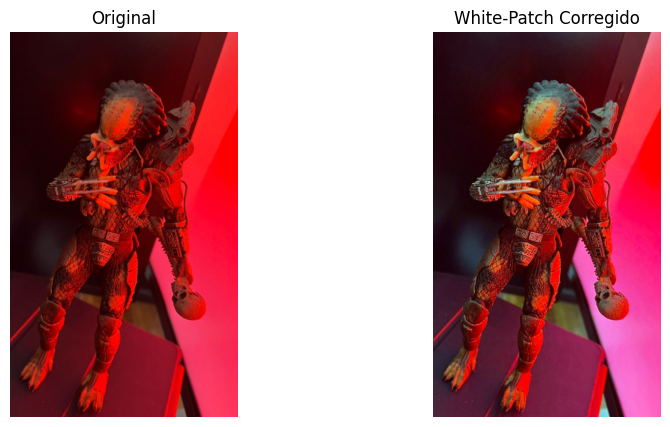

/content/drive/MyDrive/Material_TPs/TP1/white_patch/test_blue.png


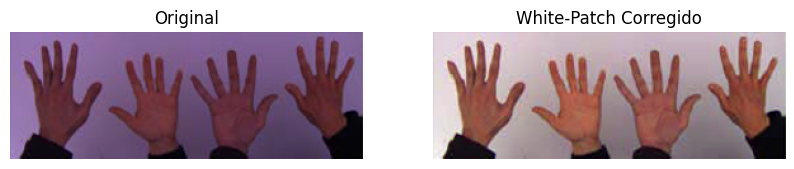

/content/drive/MyDrive/Material_TPs/TP1/white_patch/test_green.png


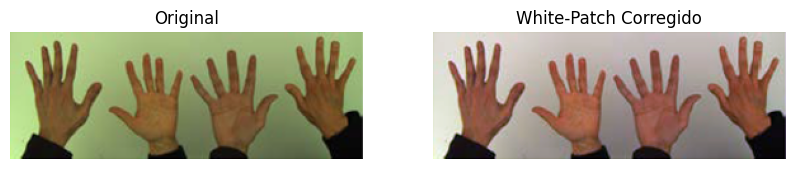

In [19]:
white_patch = '/content/drive/MyDrive/Material_TPs/TP1/white_patch'
rutas = glob(white_patch + '/*.png')
for ruta in rutas:
    print(ruta)
    orig = cv2.imread(ruta)
    corr = white_patch_correction(orig)

    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    corr_rgb = cv2.cvtColor(corr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(orig_rgb)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(corr_rgb)
    plt.title('White‑Patch Corregido')
    plt.axis('off')
    plt.show()

Podemos notar, mas que anda en las manos, que no se corrige el contraste de la imagen, con lo cual no hay una mejora con las sombras de las manos ya que white patch solo ajusta el balance del color.

Con la imagen de la figura, podemos ver que hay bastante ruisdo en la foto y no se percibe una mejora qen estas. Ademas podemos ver como en la cabeza se genera un brillo de blanco mas grande del que se puede percibir, y en un lugar donde no parece que haya una fuente de iluminacion.

In [34]:
def showGrayScaleImages(img_paths):
    """
    Lee con OpenCV en escala de grises y visualiza cada imagen.
    """
    for path in img_paths:
        # Leer en modo grayscale
        img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img_gray is None:
            print(f'No se pudo leer: {path}')
            continue

        plt.figure(figsize=(6, 6))
        plt.imshow(img_gray, cmap='gray')
        plt.title(f'Imagen en Grises: {path.split("/")[-1]}')
        plt.axis('off')
        plt.show()

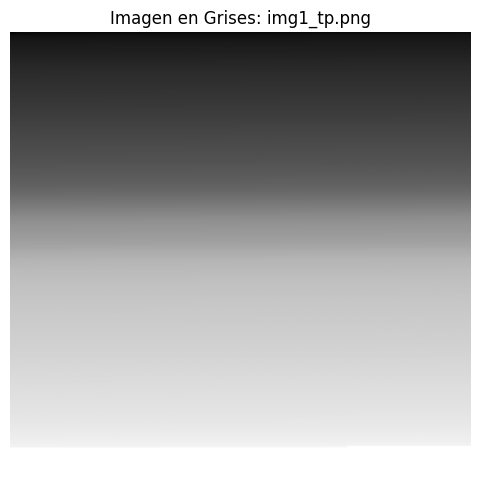

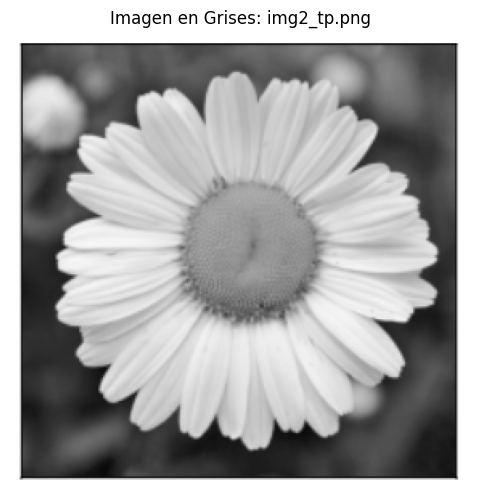

In [37]:
images = ['/content/drive/MyDrive/Material_TPs/TP1/img1_tp.png', '/content/drive/MyDrive/Material_TPs/TP1/img2_tp.png']
showGrayScaleImages(images)

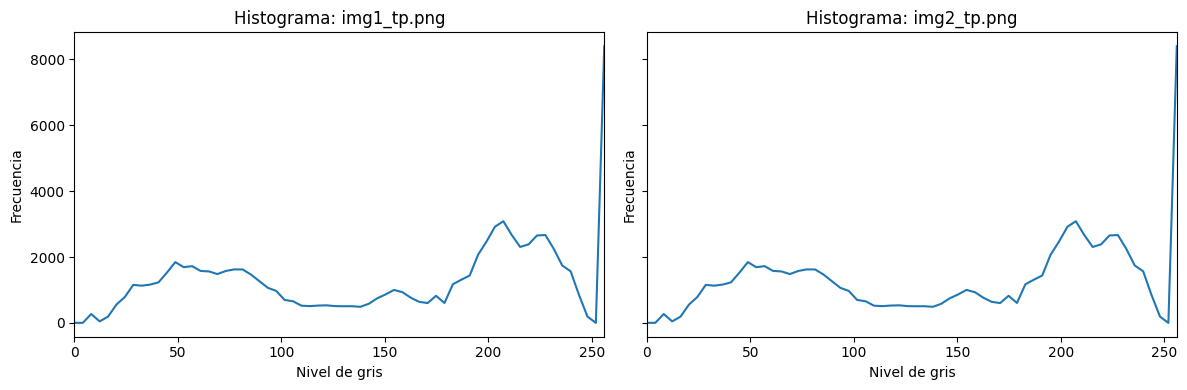

In [39]:
# número de bins para el histograma
bins = 64
imgs_gray = [cv2.imread(p, cv2.IMREAD_GRAYSCALE) for p in images]
hists = [cv2.calcHist([img], [0], None, [bins], [0, 256]).flatten() for img in imgs_gray]


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, hist, path in zip(axes, hists, images):
    ax.plot(np.linspace(0, 256, bins), hist)
    ax.set_title(f'Histograma: {path.split("/")[-1]}')
    ax.set_xlabel('Nivel de gris')
    ax.set_ylabel('Frecuencia')
    ax.set_xlim(0, 256)
plt.tight_layout()
plt.show()

Podemos ver que la distribucion es muy parecida entre ambas imagenes, lo que significa que el nivel de gris es muy similar en ambas imagenes y que ambas tienen un contraste y brillo parecidos.

Entre los valores de grises 30 y 100 se ve una meseta que quiere decir que muestra detalle para sombras medias. Mientras que la otra meseta entre los valores 200 y ~240 indica que muestra detalle con luces mas altas.

Lo que podemos definir como una ventaja a traves de los histogramas es que capturan bien las diferencias en la iluminacion global entre imagenes diferentes. Pero esto a la vez es una contra ya que unas imagenes muy distintas pueden tener histogramas similares, por lo que si se usa solo el histograma, queda evidente con estas 2 imagenes, que va a cofundir a cualquiera que los vea sin ver las imagenes. Adfemas los picos en la derecha pueden opacar las variaciones de grises.

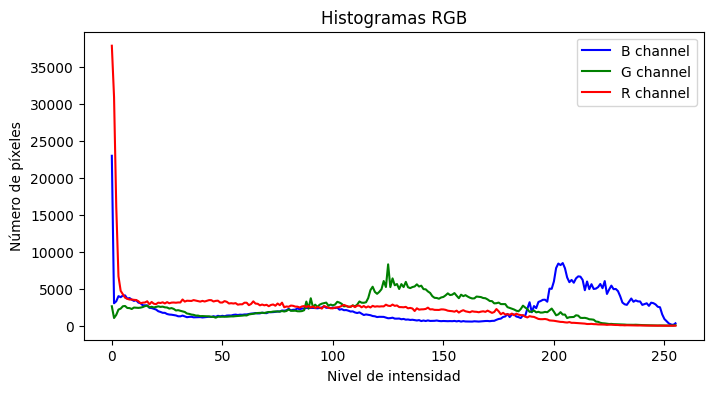

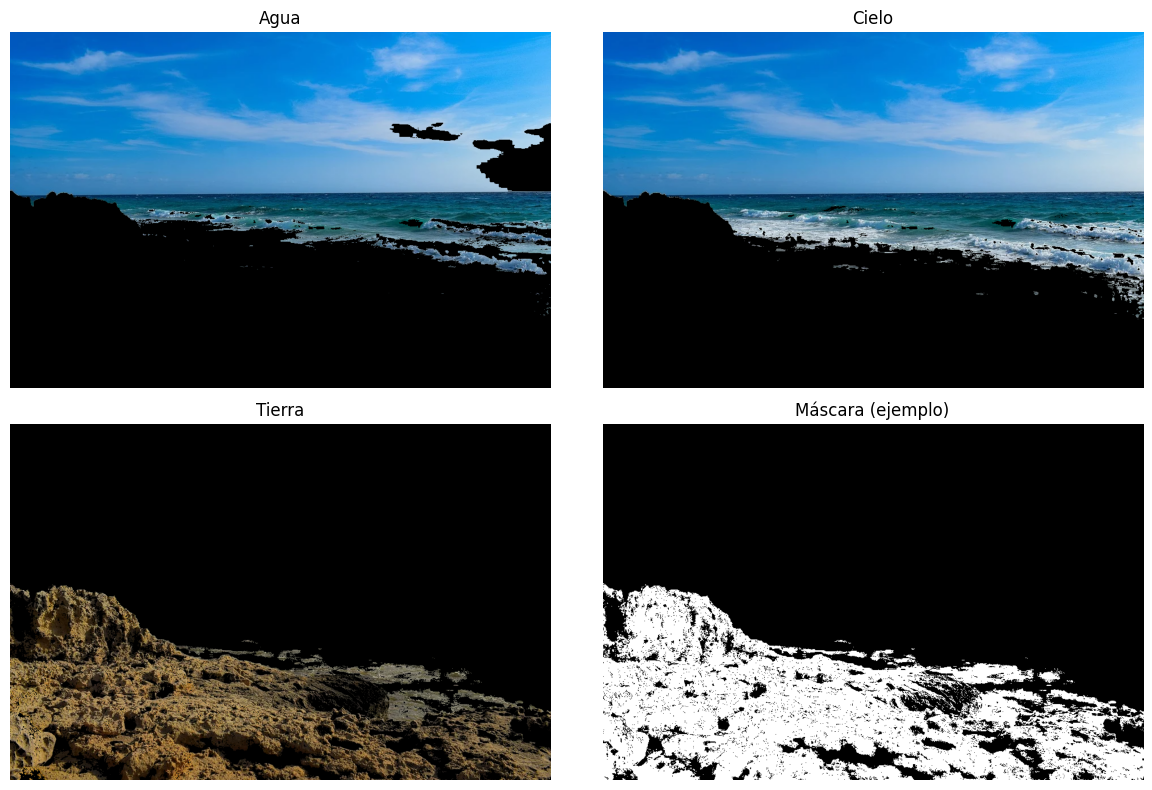

In [6]:
img = cv2.imread('/content/drive/MyDrive/Material_TPs/TP1/segmentacion.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Histograma RGB
plt.figure(figsize=(8,4))
for i, col in enumerate(('b','g','r')):
    hist = cv2.calcHist([img], [i], None, [256], [0,256])
    plt.plot(hist, color=col, label=f'{col.upper()} channel')
plt.title('Histogramas RGB')
plt.xlabel('Nivel de intensidad')
plt.ylabel('Número de píxeles')
plt.legend()
plt.show()

# Convertimos a HSV para segmentación por color
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Definimos rangos HSV para cada región
ranges = {
      'agua':  ((90,  60,  40),  (140, 255, 255)),
      'cielo': ((90,  20,  60), (135, 255, 255)),
      'tierra':((  5,  30,  30),  ( 30, 255, 200)),
}

# Aplicamos máscaras
plt.figure(figsize=(12,8))
masks = {}

for i, (name, (low, high)) in enumerate(ranges.items(), 1):
    low = np.array(low, dtype=np.uint8)
    high = np.array(high, dtype=np.uint8)
    mask = cv2.inRange(hsv, low, high)
    # masks[name] = mask

    segmented = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    plt.subplot(2, 2, i)
    plt.imshow(segmented)
    plt.title(name.capitalize())
    plt.axis('off')


plt.subplot(2, 2, 4)
plt.imshow(mask, cmap='gray')
plt.title('Máscara (ejemplo)')
plt.axis('off')

plt.tight_layout()
plt.show()